In [36]:
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree

iris = load_iris()
X, y = iris.data, iris.target
print(X.shape, y.shape)


(150, 4) (150,)


In [37]:
def entropia(y):
    entropia = 0
    classes = np.unique(y)
    
    for classe in classes:
        proporcao = np.mean(y == classe)                
        entropia -= proporcao * np.log2(proporcao)
    
    return entropia

entropia(y)

1.584962500721156

In [40]:
def ganho(x, y):

    media_valores = np.mean(x)               
    maiores = x > media_valores #sei quem sao os maiores que a média    
    total = sum(maiores) + sum(~maiores)    
    prop_maiores = sum(maiores)/total
    prop_menores = sum(~maiores)/total
    '''print('entropia geral: ',entropia(y))
    print('prop_maiores: ', prop_maiores) 
    print('prop_menores: ', prop_menores)
    print('entropia(y[maiores]): ', entropia(y[maiores]))
    print('entropia(y[~maiores]): ', entropia(y[~maiores]))    '''
    return entropia(y) - prop_maiores*entropia(y[maiores]) - prop_menores*entropia(y[~maiores])

def caracteristica_maior_ganho(X, y):
    maior_ganho = 0
    caracteristica = 0
    for i in range(X.shape[1]):
        gain = ganho(X[:,i], y)        
        
        if gain > maior_ganho:
            maior_ganho = gain
            caracteristica = i
    
    return caracteristica

caracteristica_maior_ganho(X,y)

2

In [59]:
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class BabiTree(BaseEstimator, ClassifierMixin):    
    def fit(self, X, y):        
        self.caracteristica = caracteristica_maior_ganho(X, y)
        #print('self.caracteristica = ', self.caracteristica)
        self.valor = np.mean(X[:,self.caracteristica])        
        maiores = X[:,self.caracteristica] > self.valor        
        
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = BabiTree()
            self.maiores.fit(X[maiores,:],y[maiores])
            #print('fim maiores')
            self.menores = BabiTree()
            self.menores.fit(X[~maiores,:],y[~maiores])
            #print('fim menores')
        else:
            self.resposta = maisFrequente(y)
    
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
            #print('resposta')
        else:
            #print('else')
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = BabiTree()
modelo.fit(X,y)
ypred = modelo.predict(X)
print(f'Acurácia com re-substituição: {accuracy_score(y, ypred)}')


Acurácia com re-substituição: 1.0


In [60]:
score_cv = cross_validate(BabiTree(), X, y)
print('Acurácia com validação cruzada: ', np.mean(score_cv['test_score']))

Acurácia com validação cruzada:  0.9333333333333332


# Arvore do Sklearn

In [45]:
tree_sklearn = DecisionTreeClassifier()
tree_sklearn.fit(X, y)
ypred_tree_sklearn = tree_sklearn.predict(X)
print(f'Acurácia com re-substituição: {accuracy_score(y, ypred)}')

Acurácia com re-substituição: 1.0


In [46]:
tree_sklearn = DecisionTreeClassifier()
score_cv_tree_sklearn = cross_validate(tree_sklearn, X, y)
print('Acurácia com validação cruzada: ', np.mean(score_cv_tree_sklearn['test_score']))

Acurácia com validação cruzada:  0.9600000000000002


# Gráficos

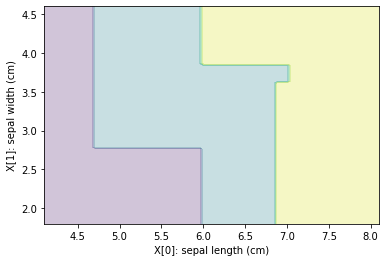

In [89]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x2s = np.linspace(np.min(X[:,2])-0.2, np.max(X[:,2])+0.2, 100)    
    x3s = np.linspace(np.min(X[:,3])-0.2, np.max(X[:,3])+0.2, 100)    
    x0, x1 = np.meshgrid(x0s, x1s)    
    x2, x3 = np.meshgrid(x2s, x3s)            
    Xdec = np.c_[x0.ravel(), x1.ravel(), x2.ravel(), x3.ravel()]        
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    '''
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    '''
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

plotDecisao(BabiTree(), X, y)